# Clustering particles

In [2]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [3]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_2m_1f_240219_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [70, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [4]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 54110
Frames resolution: 1080 x 1920


In [5]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [6]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,120.145605,264.010191,121.014025,264.957801,NaN,120.145605,264.010191,NaN,120.145605,264.010191,-0.339188,7850.0,186.367623,116.741012,0.779500,4
1,1,0,84.730201,407.067829,87.590942,407.276469,NaN,84.730201,407.067829,NaN,84.730201,407.067829,-1.542622,2639.0,96.478333,74.097902,0.640418,4
2,2,0,1193.183921,970.228535,1185.783301,969.802004,0.0,1233.000000,929.000000,0.619608,1190.000000,1004.000000,-1.512143,13359.0,211.169999,84.729031,0.915975,4
3,3,0,362.334075,1001.592320,365.038276,1000.183289,0.0,379.000000,955.000000,0.584314,248.000000,1033.000000,-1.385676,10339.0,214.129294,75.964701,0.934957,4
4,0,3,115.338346,255.245614,118.185802,254.249005,NaN,115.338346,255.245614,NaN,115.338346,255.245614,-0.690351,399.0,225.037823,145.742978,0.761948,5
5,1,3,120.920883,268.432723,121.914182,270.100390,NaN,120.920883,268.432723,NaN,120.920883,268.432723,-0.279048,7432.0,181.490721,112.712780,0.783780,5


In [7]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         4   120.145605   264.010191    -0.339188
1   1     0         4    84.730201   407.067829    -1.542622
2   2     0         4  1193.183921   970.228535    -1.512143
3   3     0         4   362.334075  1001.592320    -1.385676


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,120.145605,264.010191,121.014025,264.957801,NaN,120.145605,264.010191,NaN,120.145605,264.010191,-0.339188,7850.0,186.367623,116.741012,0.779500,4
2,1,0,1193.183921,970.228535,1185.783301,969.802004,0.0,1233.000000,929.000000,0.619608,1190.000000,1004.000000,-1.512143,13359.0,211.169999,84.729031,0.915975,4
3,2,0,362.334075,1001.592320,365.038276,1000.183289,0.0,379.000000,955.000000,0.584314,248.000000,1033.000000,-1.385676,10339.0,214.129294,75.964701,0.934957,4
4,0,3,115.338346,255.245614,118.185802,254.249005,NaN,115.338346,255.245614,NaN,115.338346,255.245614,-0.690351,399.0,225.037823,145.742978,0.761948,5
5,1,3,120.920883,268.432723,121.914182,270.100390,NaN,120.920883,268.432723,NaN,120.920883,268.432723,-0.279048,7432.0,181.490721,112.712780,0.783780,5
6,2,3,86.728990,411.070933,89.260847,411.368126,NaN,86.728990,411.070933,NaN,86.728990,411.070933,1.507270,2594.0,94.472806,71.287479,0.656206,5
7,3,3,1193.357442,970.083022,1185.977590,969.685029,0.0,1185.000000,929.000000,0.654902,1210.000000,998.000000,-1.509430,13370.0,211.516828,84.825293,0.916063,5


In [8]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
35037,3,54105,1513.166667,1022.524718,1513.051980,1022.561298,0.0,1534.000000,1012.000000,0.482353,1536.000000,1015.000000,1.505337,1416.0,103.416172,25.044762,0.970233,4
35038,0,54108,413.959008,140.815477,422.371633,144.261504,NaN,413.959008,140.815477,NaN,413.959008,140.815477,0.986492,16735.0,238.572156,95.044345,0.917217,4
35039,1,54108,91.268967,213.502004,92.700504,211.831797,NaN,91.268967,213.502004,NaN,91.268967,213.502004,-0.231831,6986.0,210.623143,115.860608,0.835109,4
35040,2,54108,602.099114,914.893107,596.480112,913.554588,0.0,557.000000,824.000000,0.772549,470.000000,854.000000,1.212093,12985.0,254.877118,91.199562,0.933791,4
35041,3,54108,1513.262518,1022.448498,1513.150162,1022.484477,0.0,1534.000000,1012.000000,0.482353,1535.000000,1015.000000,1.503570,1398.0,103.166706,24.920376,0.970387,4


## Velocities distribution in each frame

In [9]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


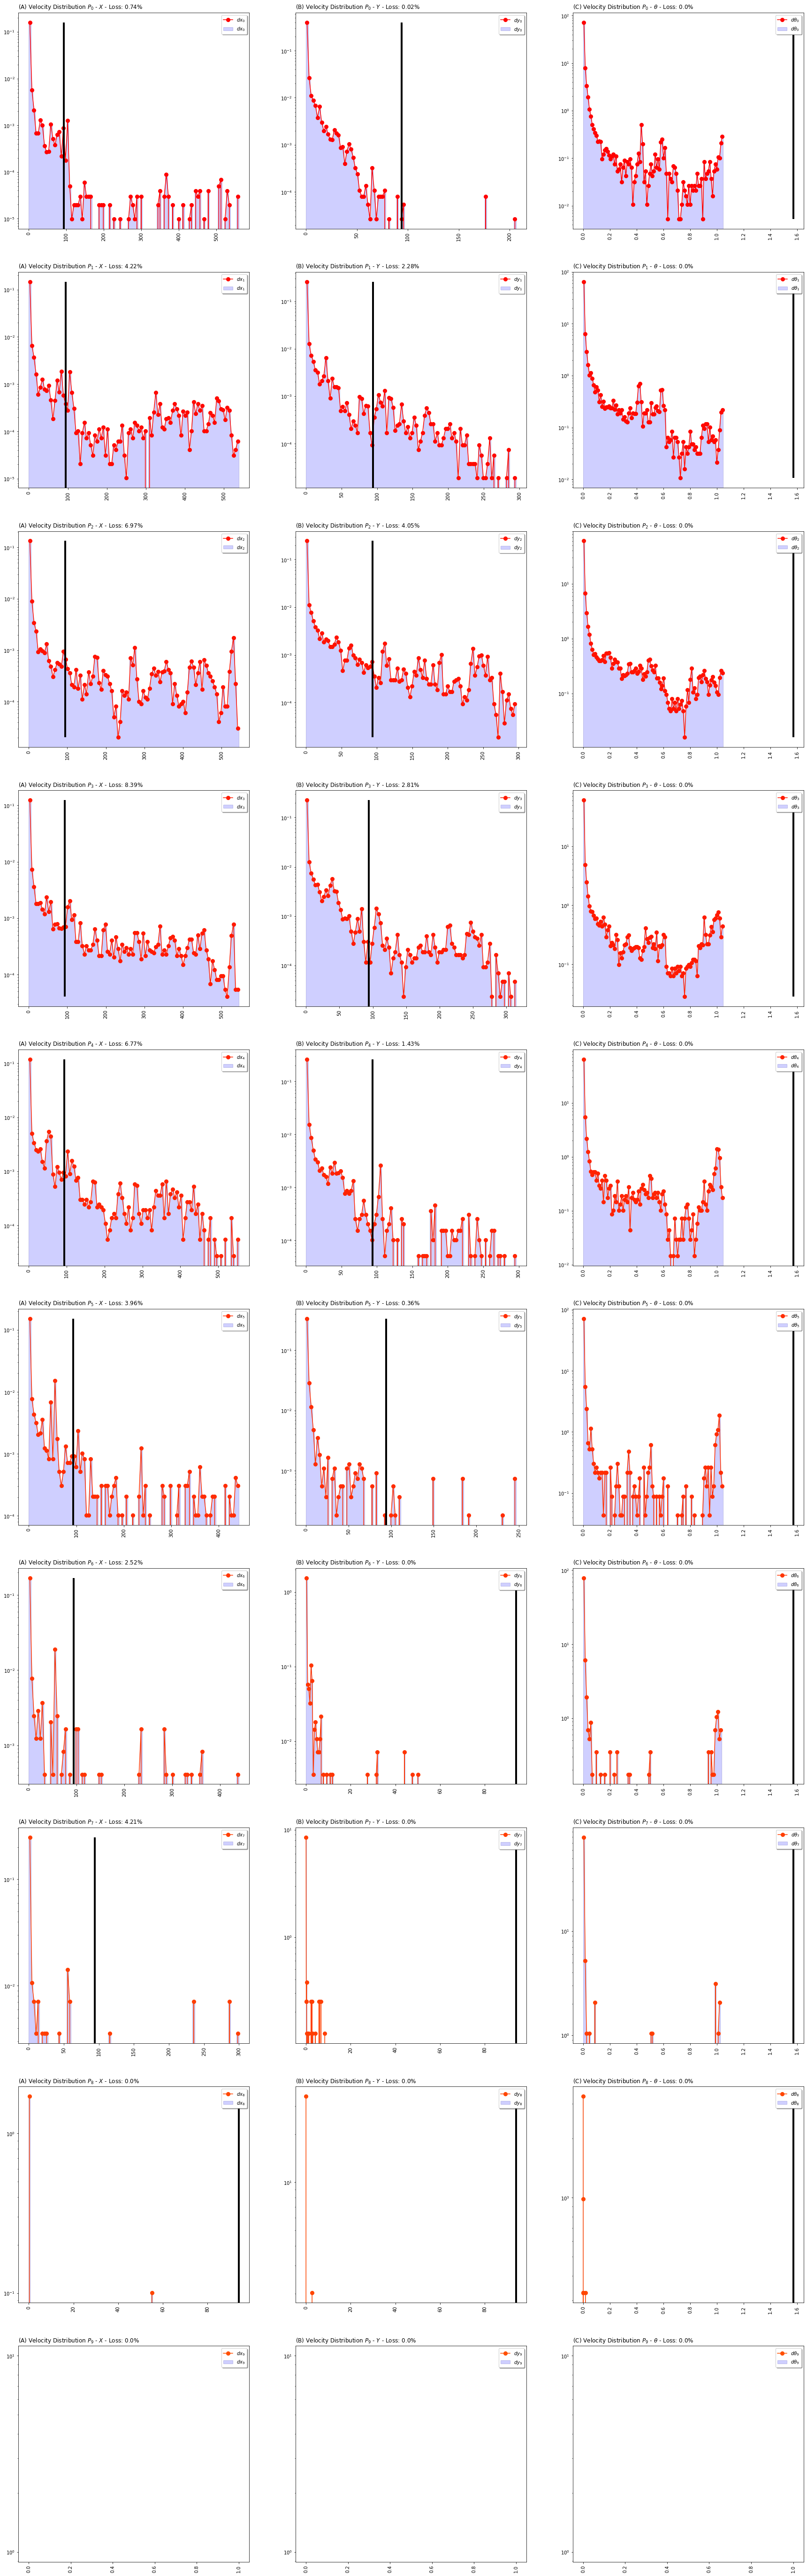

In [10]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [11]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,32
1,3,13452
2,4,27907
3,5,21810
4,6,9852
5,7,3227
6,8,608
7,9,162
8,10,10


## Clustering frames

In [12]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 50.346349825098066 



In [13]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [14]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.033740
1,2,False,True,False,0.002595
2,2,True,False,False,0.002595
3,2,True,True,False,0.002595
4,3,False,False,False,16.611731
5,3,False,True,False,0.249157
6,3,True,False,False,0.346483
7,3,True,True,False,0.249157
8,4,False,False,False,34.043602
9,4,False,True,False,0.381521


In [15]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 14.565878063132976 
	- Angle: 50.346349825098066 



In [16]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0036963793963812447%
Final loss data X-axis: 1.580202191952982%
Final loss data Y-axis: 1.6707634871643224%
Final loss data Angle : 0.9813887297392205%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,2,True,True,True,0.003696
1,3,False,False,False,0.033267
2,3,False,False,True,0.726339
3,3,False,True,False,0.072079
4,3,False,True,True,0.748517
5,3,True,False,False,0.011089
6,3,True,False,True,0.900068
7,3,True,True,False,0.864953
8,3,True,True,True,96.639991


In [17]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 14.565878063132976 
	- Angle: 50.346349825098066 



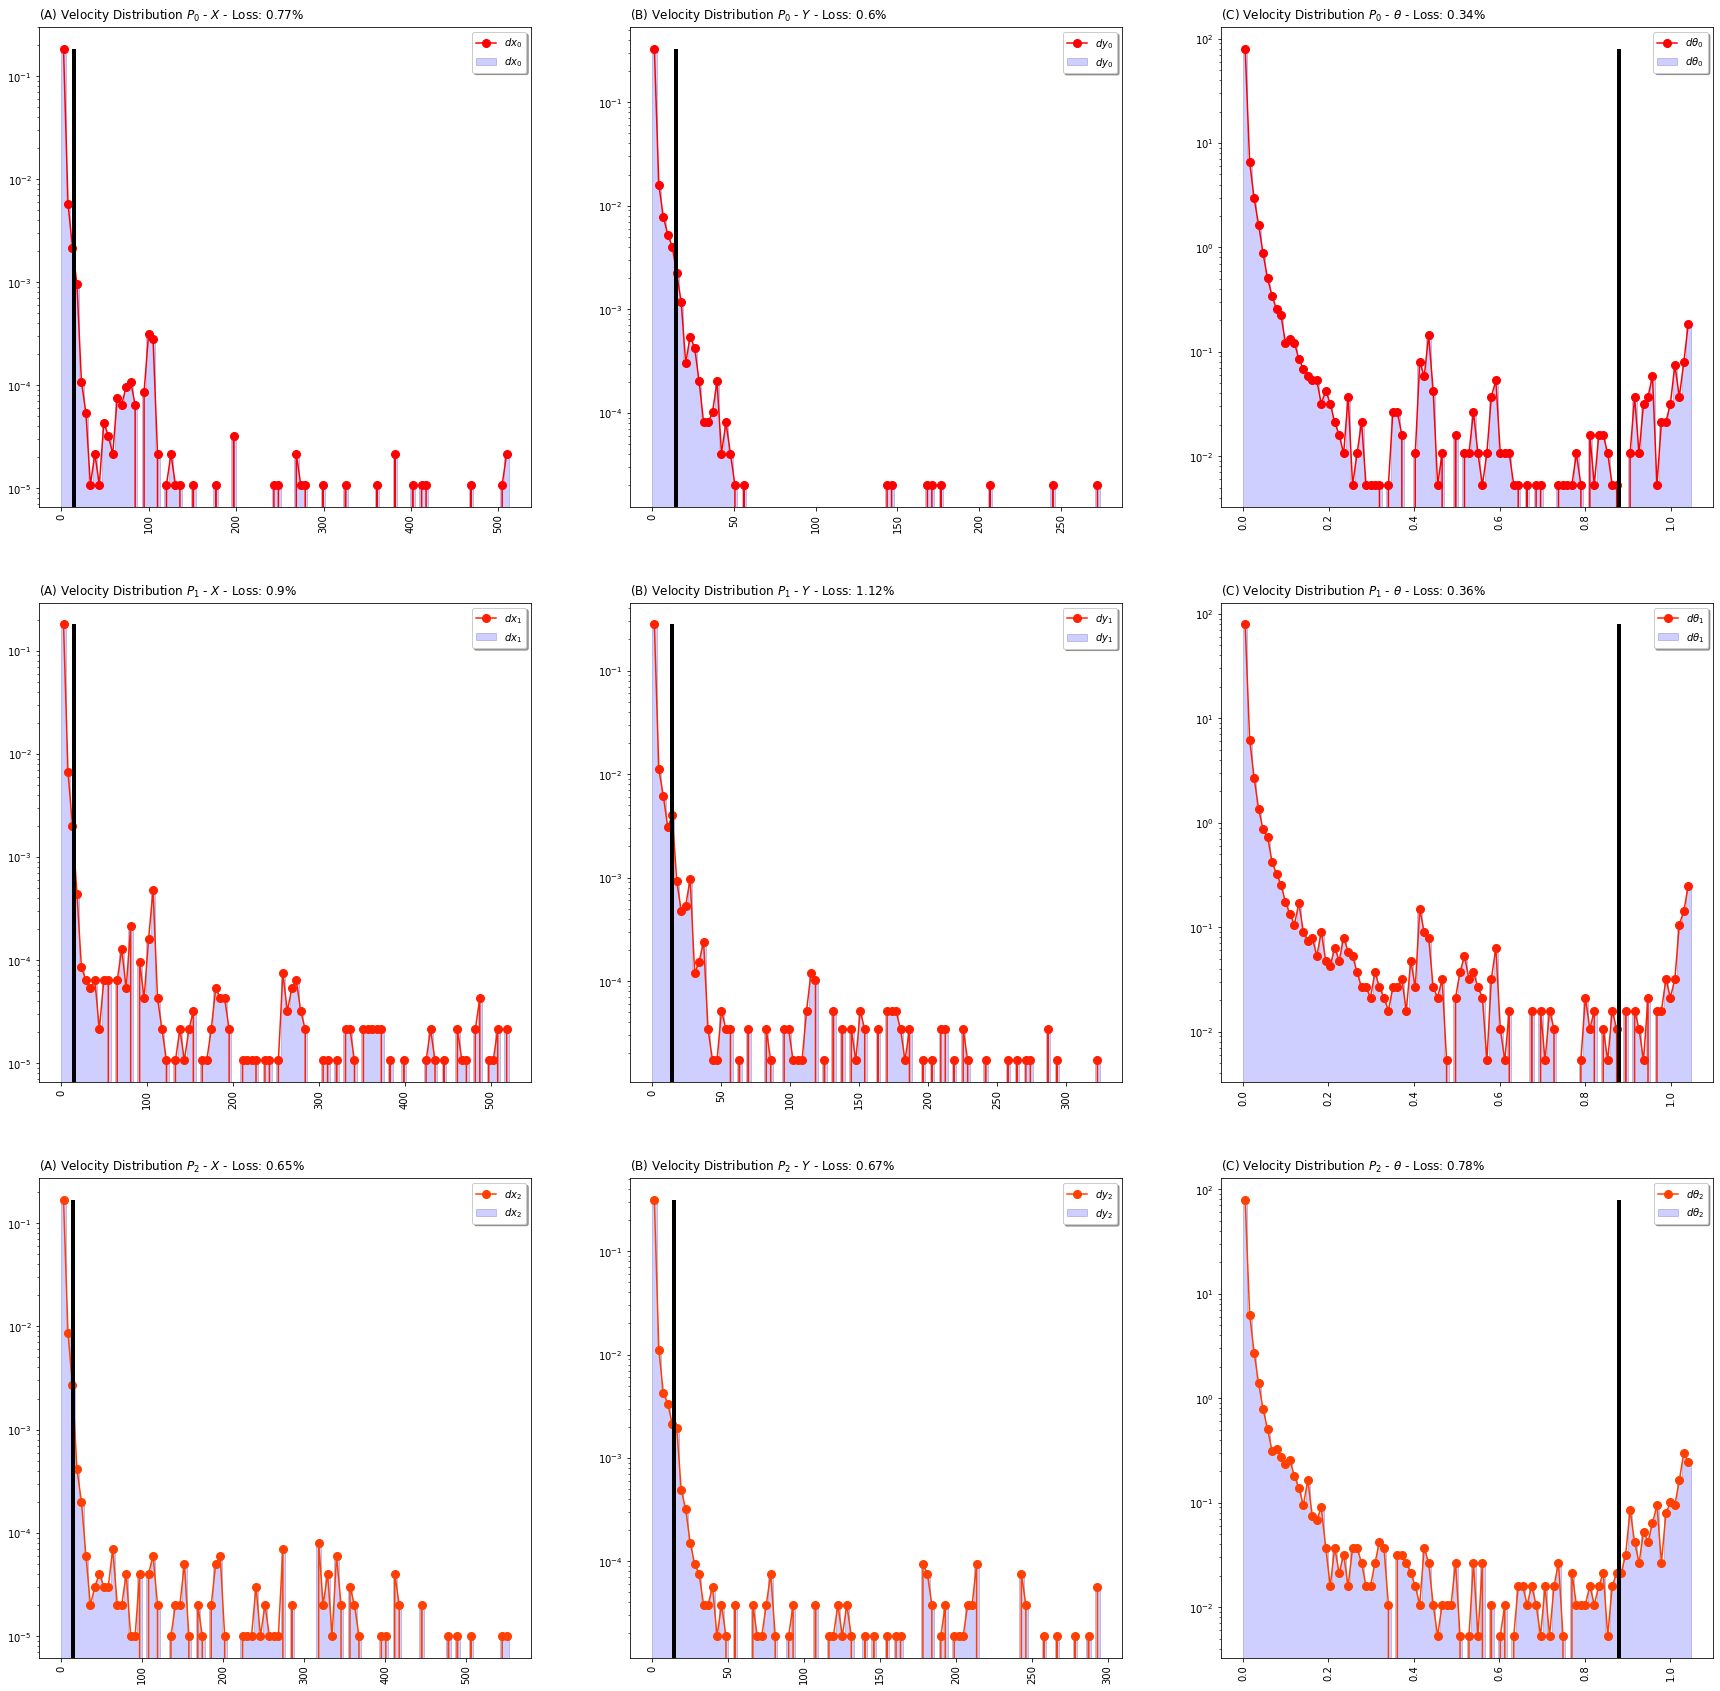

In [18]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [19]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [20]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,120.145605,264.010191,121.014025,264.957801,NaN,120.145605,264.010191,NaN,120.145605,264.010191,-0.339188,7850.0,186.367623,116.741012,0.779500,3,NaN,NaN,NaN,NaN,False,False,False
4484,1,0,1193.183921,970.228535,1185.783301,969.802004,0.0,1233.000000,929.000000,0.619608,1190.000000,1004.000000,-1.512143,13359.0,211.169999,84.729031,0.915975,3,NaN,NaN,NaN,NaN,False,False,False
8969,2,0,362.334075,1001.592320,365.038276,1000.183289,0.0,379.000000,955.000000,0.584314,248.000000,1033.000000,-1.385676,10339.0,214.129294,75.964701,0.934957,3,NaN,NaN,NaN,NaN,False,False,False
13454,0,3,118.129614,261.839169,120.049992,262.174697,NaN,118.129614,261.839169,NaN,118.129614,261.839169,-0.690351,399.0,225.037823,145.742978,0.761948,3,3.0,-0.671997,-0.723674,-0.117054,False,False,False
13455,1,3,1193.357442,970.083022,1185.977590,969.685029,0.0,1185.000000,929.000000,0.654902,1210.000000,998.000000,-1.509430,13370.0,211.516828,84.825293,0.916063,3,3.0,0.057840,-0.048504,0.000904,False,False,False
13456,2,3,372.556078,999.891813,375.453078,998.374357,0.0,358.000000,955.000000,0.584314,326.000000,1039.000000,-1.343745,9576.0,165.168481,78.123037,0.881068,3,3.0,3.407334,-0.566836,0.013977,False,False,False
13457,0,6,131.555746,287.398866,131.641112,292.510445,NaN,131.555746,287.398866,NaN,131.555746,287.398866,0.355817,296.0,212.194687,102.650936,0.875202,3,3.0,4.475377,8.519899,0.348723,False,False,False
13458,1,6,1193.438551,969.548877,1185.956885,969.133267,0.0,1181.000000,929.000000,0.666667,1139.000000,998.000000,-1.513794,13442.0,211.894372,85.307659,0.915378,3,3.0,0.027036,-0.178048,-0.001455,False,False,False
13459,2,6,372.379008,999.949138,375.135099,998.476767,0.0,381.000000,955.000000,0.596078,323.000000,1005.000000,-1.349763,9575.0,166.368421,77.891810,0.883629,3,3.0,-0.059023,0.019109,-0.002006,False,False,False


## Visualize final data

In [21]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


In [22]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_2m_1f_240219_1_c.zip'